In [1]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/figure2_theme.R"))

library(tidyverse)
library(ggrepel)
library(RColorBrewer)
library(gridExtra)
library(ggpubr)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.1.2     ✔ forcats 0.5.1
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”── Conflicts ────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



##### Put in settings

In [2]:
ingredients <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds")) %>% mutate(Direction = factor(ifelse(Direction == "Worse", "Worse Outcome", "Better Outcome"), levels = c("Worse Outcome", "Better Outcome")))
labels <- readRDS(paste0(TMP_DIR,"exhaustive-plots-labels.Rds"))
labels$size <- labels$size
threshold <- -log10(ingredients$by_05_fdr)[1]

Warning message:
“Unknown or uninitialised column: `size`.”

##### Plots

In [3]:
size_map <- list( "TRUE" = 4, "FALSE" = 2)
alpha_map <- list( "TRUE" = 1, "FALSE" = .4)
color_map <- list( "TRUE" = "black", "FALSE" = "white")
shape_map <- list(  "Better Outcome" = 24, "Worse Outcome" = 25)
fill_map <- list("Clinical"="#9E7788",
                 "CNV/SVs"="#B3DE69",
                 "HLA"="#FFFF99",
                 "RNA: Remaining"= "#E0BA92", #"#FC913A",
                 "Somatic"="#80B1D3",
                 "RNA: T-cell" = "#FB8072",
                 "RNA: TGFB" = "#BEBADA", 
                 "RNA: Proliferation" = "#8DD3C7")

In [4]:
aes_tmb <- aes(x = cor_tmb, y = log10_p, shape = Direction, fill = discovery_group, size = log10_p > threshold, alpha = log10_p > threshold, color = log10_p > threshold ) #+ guides_main
aes_tcell <- aes(x = cor_tcell, y = log10_p, shape = Direction, fill = discovery_group, size = log10_p > threshold, alpha = log10_p > threshold, color = log10_p > threshold ) #+ guides_main
aes_pretreat <- aes(x = cor_pretreat, y = log10_p, shape = Direction,fill = discovery_group, size = log10_p > threshold, alpha = log10_p > threshold, color = log10_p > threshold ) #+ guides_main
aes_tgfb <- aes(x = cor_tgfb, y = log10_p, shape = Direction,fill = discovery_group, size = log10_p > threshold, alpha = log10_p > threshold, color = log10_p > threshold ) #+ guides_main
aes_prolif <- aes(x = cor_prolif, y = log10_p, shape = Direction, fill = discovery_group, size = log10_p > threshold, alpha = log10_p > threshold, color = log10_p > threshold ) #+ guides_main

In [5]:
guides_main <- guides(alpha = "none", size = "none", color = "none", shape = guide_legend(override.aes = list(size=7, ncol = 2)), fill = guide_legend(override.aes = list(shape=21, size=7, ncol=2)))

In [6]:
all <- ingredients %>% filter(dataset == "all")

In [7]:
max_y <- max(all %>% filter(covariates == "age_biopsy_purity_tissue") %>% pull(log10_p))

In [8]:
plots_go <- function( df = all, type = "tmb",  xlab = "X", title = "X"){
    if( type == "tmb"){ gg <- ggplot(df, aes_tmb) } 
    else if (type == "tcell"){gg <- ggplot(df, aes_tcell) } 
    else if (type == "pre"){ gg <- ggplot(df, aes_pretreat)}
    else if (type == "tgfb"){ gg <- ggplot(df, aes_tgfb)}
    else if (type == "prolif"){ gg <- ggplot(df, aes_prolif)}
    (gg + 
        geom_point(stroke = 0.3) + 
        scale_y_continuous(breaks = c(seq(0,max_y,2)), limits = c(0,max_y)) + 
        scale_x_continuous(n.breaks = 3)  +
        scale_size_manual(values = unlist(size_map))  +
        scale_alpha_manual(values = unlist(alpha_map)) + 
        scale_color_manual(values = unlist(color_map) ) + 
        scale_shape_manual(values = unlist(shape_map)) + 
        scale_fill_manual(values = unlist(fill_map), limits = force) + 
        geom_hline( yintercept = threshold, linetype="dashed", color = "black" ) + 
        xlab( xlab ) + 
        ylab("-Log10 p-value") +  
        ggtitle( title) +
        base_theme
    )
}

In [9]:
remove_y  <- theme(axis.text.y=element_blank(), axis.title.y=element_blank())

In [10]:
make_layer <- function( df = all, type = "tmb", overall_title = "X", aes_go = aes_tmb, xlab = "Correlation TMB" ){
    p1 <- plots_go(df %>% filter(model == "bor", covariates == "age_biopsy_purity_tissue"), type = type, xlab = xlab, title = paste0("BOR vs All features"))
    p2 <- plots_go(df %>% filter(model == "pfs", covariates == "age_biopsy_purity_tissue"), type = type, xlab = xlab, title = paste0("PFS vs All features")) + remove_y
    p3 <- plots_go(df %>% filter(model == "os", covariates == "age_biopsy_purity_tissue"), type = type, xlab = xlab, title = paste0("OS vs All features")) + remove_y
    p4 <- plots_go(df %>% filter(model == "os", covariates == "residuals"), type = type, xlab = xlab, title = paste0("OS Residuals vs All features")) + remove_y
    legend <- get_legend(p3 + theme(legend.position = "right") + guides_main)
    
    if( type %in% c("tmb", "tcell","pre")){
        as_ggplot(arrangeGrob(p1,p2,p3, ncol = 3)) + theme(plot.title = element_text(size = 18, vjust = 0, hjust = .4)) + ggtitle(overall_title) + theme(plot.margin = margin(.1,.1,.1,.1, "cm"))
    } else {
        as_ggplot(arrangeGrob(p1,p3,p4, ncol = 3)) + theme(plot.title = element_text(size = 18, vjust = 0, hjust = .4)) + ggtitle(overall_title) + theme(plot.margin = margin(.1,.1,.1,.1, "cm"))      
    }
}

In [11]:
options(repr.plot.width = 14, repr.plot.height = 4.5)

In [12]:
annote <- function( i, lab ) annotate_figure( i, fig.lab = lab, fig.lab.size = 18, fig.lab.face = "bold")

In [13]:
tmb <- annote(make_layer(df = all, overall_title = "Signficance vs Correlation with TMB Cluster", type = "tmb", xlab = "Correlation TMB"), "A")
pre <- annote(make_layer(df = all, overall_title = "Signficance vs Correlation with Pretreatment Cluster", type = "pre", xlab = "Correlation Pretreatment"), "B")
tcell <- annote(make_layer(df = all, overall_title = "Signficance vs Correlation with T-cell Cluster", type = "tcell", xlab = "Correlation T-cell"), "C")
tgfb <- annote(make_layer(df = all, overall_title = "Signficance vs Correlation with TGFB Cluster", type = "tgfb", xlab = "Correlation TGFB"), "D")
prolif <- annote(make_layer(df = all, overall_title = "Signficance vs Correlation with Proliferation Cluster", type = "prolif", xlab = "Correlation Proliferation"), "E")

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

In [14]:
legend <- get_legend(plots_go(all %>% filter(model == "os", covariates == "age_biopsy_purity_tissue"), title = "OS vs All features") + remove_y + theme(legend.position = "right") + guides_main+ theme(plot.margin = margin(.1,.1,.1,.1, "cm")))

In [15]:
options(repr.plot.width = 19, repr.plot.height = 14)

In [16]:
lets_go <- as_ggplot(arrangeGrob( tmb, legend, pre, tcell,  tgfb, prolif, ncol = 2)) + ggtitle("HMF CPI: Exhaustive Analysis by Correlation to 5 Latent Factors")

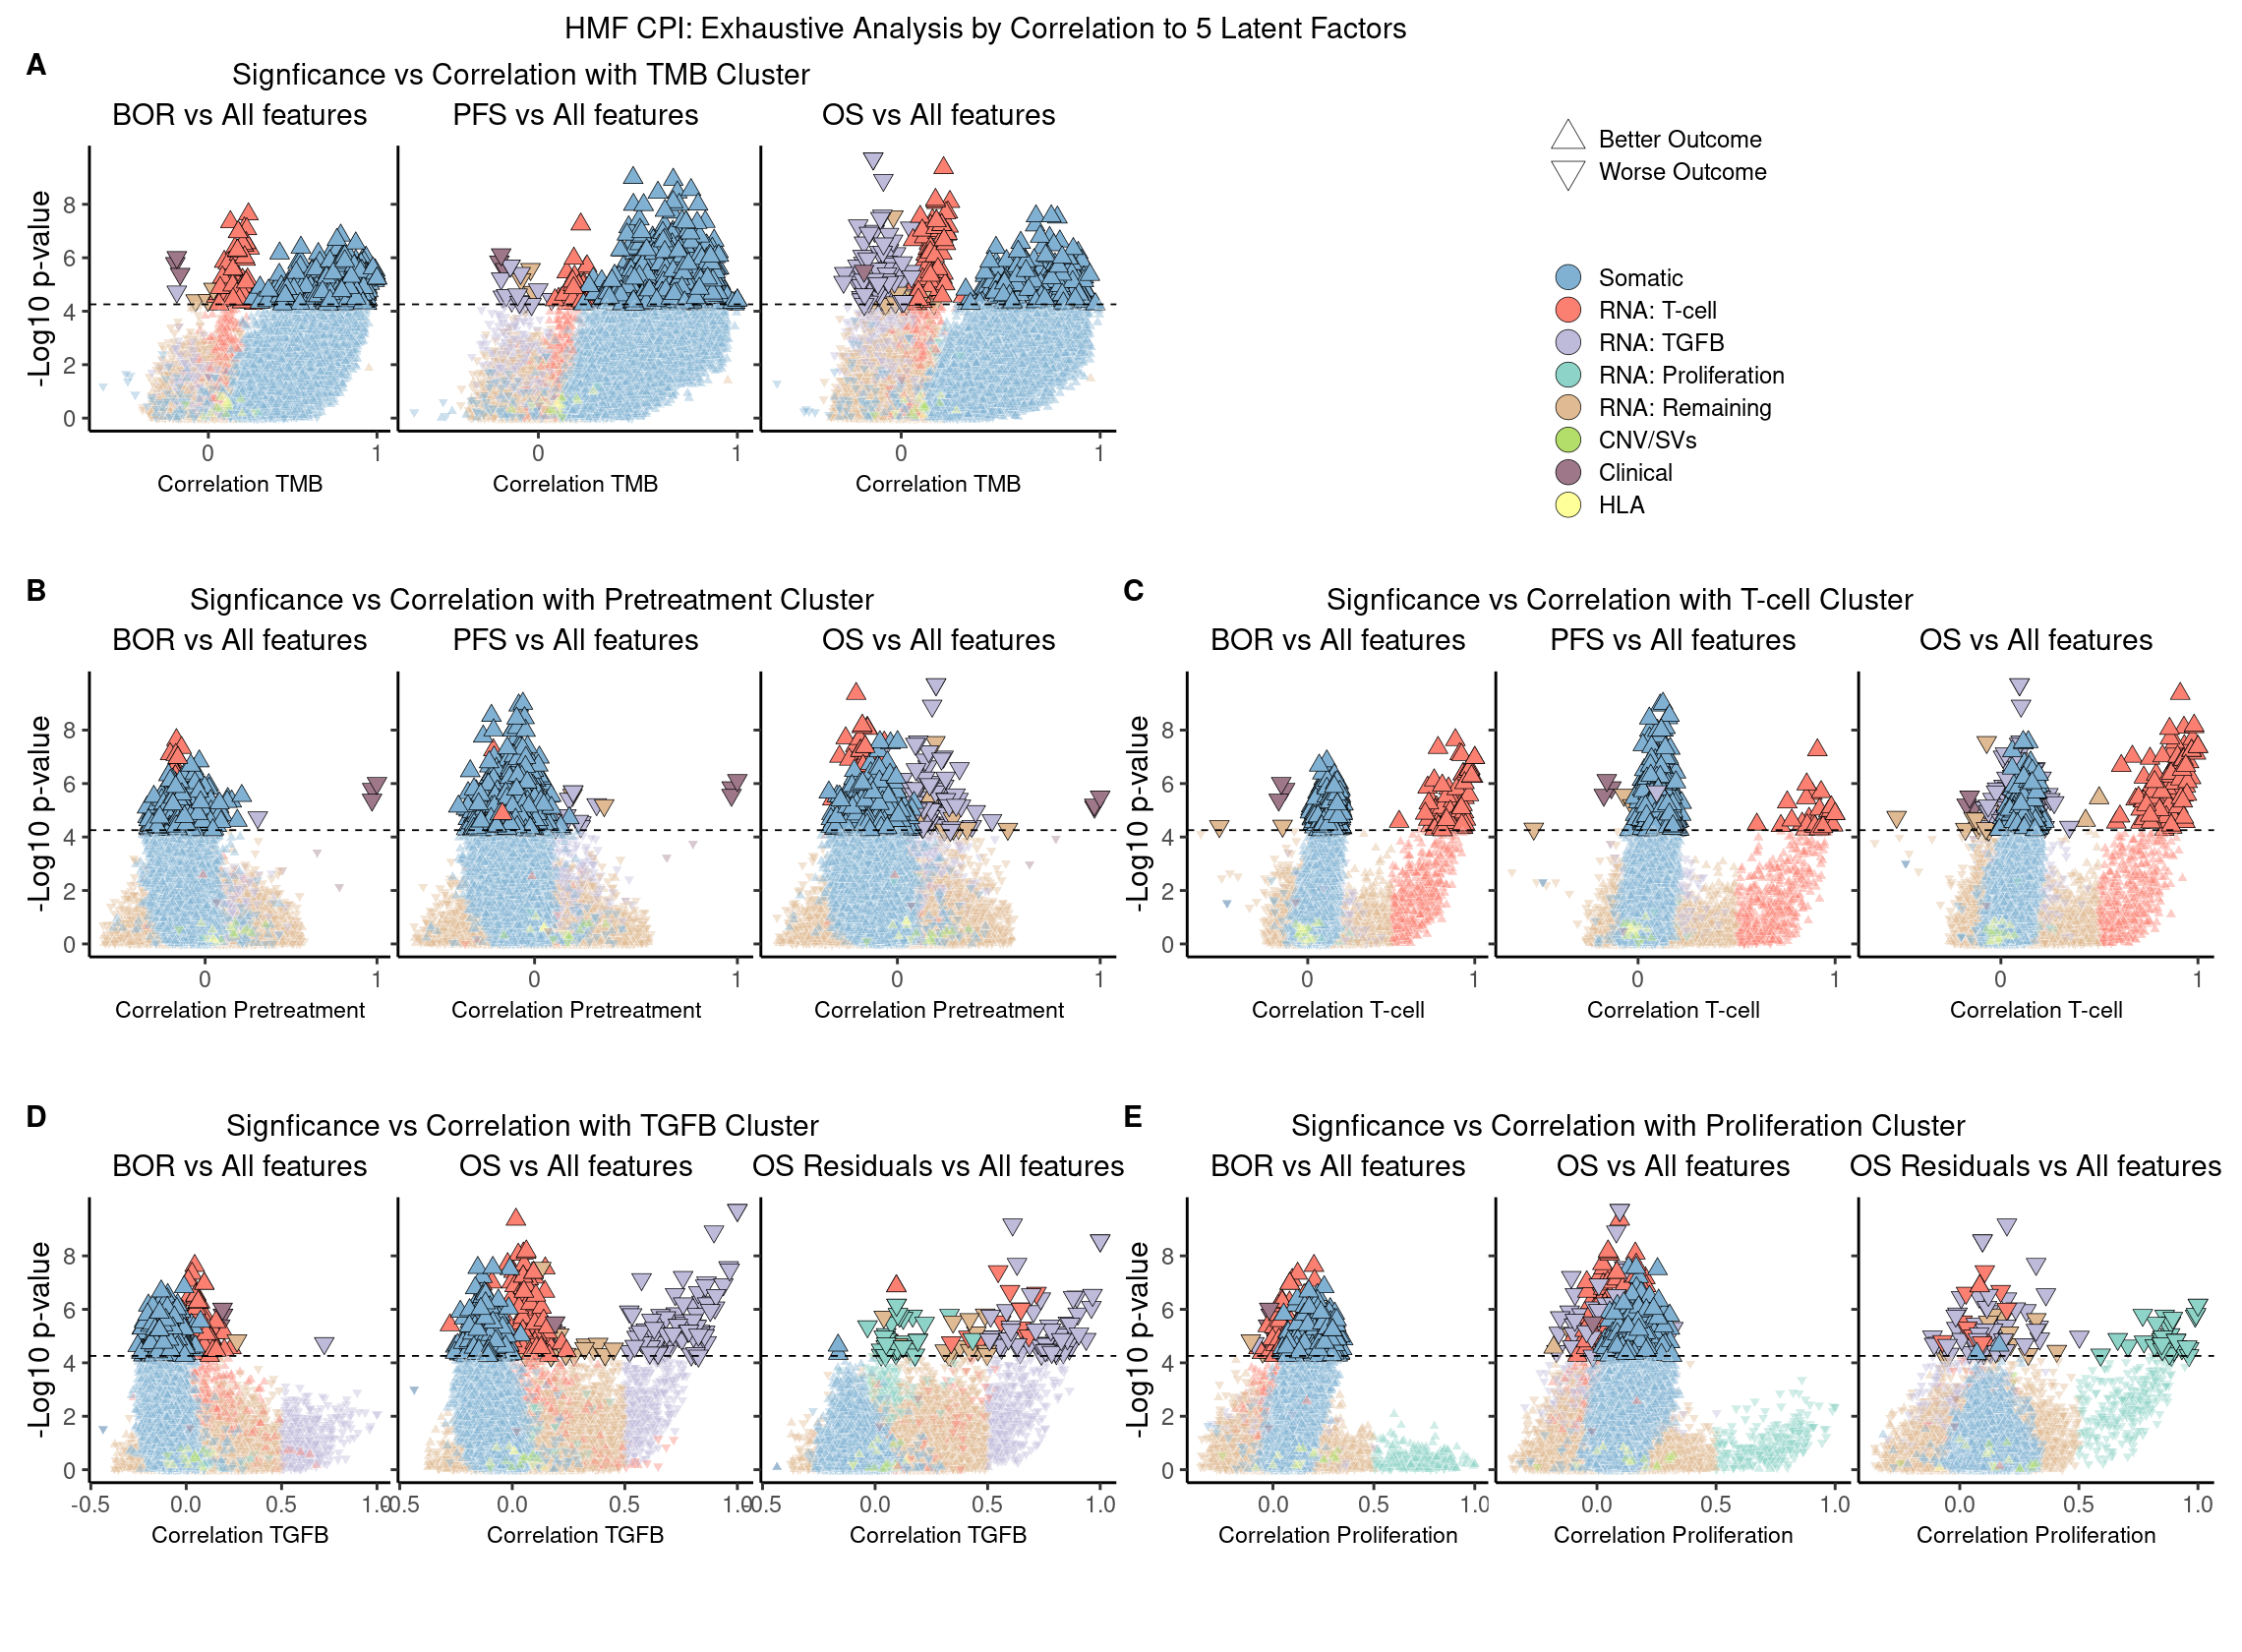

In [17]:
lets_go + theme(plot.margin = margin(.5,.5,.5,.5, "cm"), plot.title = element_text(vjust = 2, hjust = .4, size = 18))

In [18]:
ggsave(file = paste0(FIG_FINAL_DIR, "7c_supplement_note_exhaustive_correlation_go.png"), width =19, height = 14)

In [19]:
ggsave(file = paste0(FIG_FINAL_DIR, "7c_supplement_note_exhaustive_correlation_go.pdf"), width =19, height = 14)